# Inverse Model - Minimum Working Example

This notebook contains all the necessary steps to run the inverse model. It is set up as a minimum working example, running on a $10 \times 10$ node grid. The inversion should take around 4 minutes to run.

In [1]:
import ipywidgets as widgets
import netCDF4
import sys
import time
import scipy as sp
import landlab
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder, SinkFillerBarnes, FlowDirectorD8, ChannelProfiler, TrickleDownProfiler
from landlab.components.flow_accum.flow_accum_bw import find_drainage_area_and_discharge
from landlab import imshow_grid
from landlab.utils import get_watershed_mask,get_watershed_outlet,get_watershed_nodes

nb_output = sys.stdout # Location to write to console not the notebook
console_output = open('/dev/stdout', 'w') # Location to write to console

## Initialising Model space:

### Loading in Topography

Loading in the DEM of the study region to set up the model grid inside LandLab. Then the filled topography is loaded in.

In [2]:
#loading in original DEM:
zr_nc=netCDF4.Dataset('Data/Topography_100m.nc')
zr_ma = zr_nc['z'][:,:]
mg = RasterModelGrid(zr_ma.shape,xy_spacing=(100,100)) #initialise raster model grid

#load in filled topography:
topography = np.load('Data/filled_topography.npy')

landmask_nc=netCDF4.Dataset('Data/landmask.nc')
landmask = landmask_nc['z'][:,:].data.astype(float)

zr = mg.add_field('node', 'topographic__elevation', topography) #add topography to model
dx = 100

flat_shape = zr.shape # a tuple to flatten arrays [number of nodes long]
full_shape = mg.shape # the full shape of the grid [rows, columns]

# Set up the boundary conditions on the square grid
mg.set_fixed_value_boundaries_at_grid_edges(True,True,True,True)

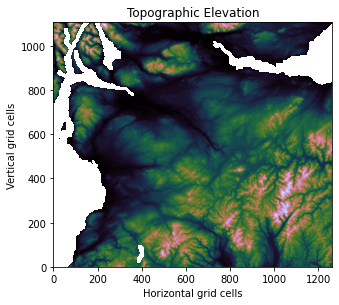

In [3]:
#Plotting filled topography
plt.figure(figsize = [5,5])
plt.title("Topographic Elevation")

plt.imshow(zr.reshape(full_shape)+landmask,cmap='cubehelix',origin='lower') 
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')
plt.show()

### Generating Drainage Network:

The next cell initiates the D8 flow routing algorithm and adds the river system to the raster model grid. In this study, a river system is defined as any stream with a drainage network $> 8km^2$

In [4]:
# instantiate the flow routing:

frr = FlowAccumulator(
    mg,
    'topographic__elevation',
    flow_director = 'FlowDirectorD8')
frr.run_one_step()  # flow routing

zrold = zr[mg.nodes] # pre-incision elevations

a, q_homo_incis = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node']) # a is number of nodes
# q is cumulative flux for homogeneous incision

area = mg.at_node['drainage_area']
np.amax(area)
area_threshold = 8 #float(sys.argv[1]) #25 km2
is_drainage = area > (area_threshold*1000000) #km2 to m2
mg.add_field('node','channels',is_drainage,clobber=True)

array([False, False, False, ..., False, False, False], dtype=bool)

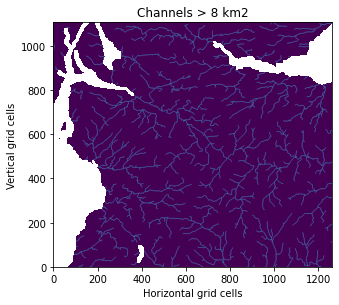

In [5]:
#Plotting drainage network:
plt.figure(figsize=[5,5])
plt.imshow(is_drainage.reshape(full_shape)+landmask,origin='lower') 
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')

plt.title("Channels > 8 km2")
plt.show()


### Adding downstream chemistry samples:

The sample localities are loaded in. For the model to work, all samples need to lie on the generated river network. Small discrepancies between loaded locations and generated river network are corrected by snapping each locality to the closest river cell. Samples are manually checked and any samples snapped to the wrong cell are corrected.

In [6]:
# loading in sample localities in following format [x, y, sample #]:
sample_data = np.loadtxt('Data/filtered_sample_loc.dat',dtype=str) 
sample_locs = sample_data[:,0:2].astype(float)

# initiating array of channel locations and nudging array:

channel_xy = np.flip(np.transpose(np.where(is_drainage.reshape(mg.shape))),axis=1)*100 # xy coordinates of channels
nudge = np.zeros(sample_locs.shape) # initiate nudging array

#nudging samples that are otherwise snapping to the wrong cell:

nudge[17] = [0,-200]    #nudging loc 632137 to S
nudge[34] = [-700,0]    #nudging loc 632164 to W
nudge[38] = [0,-400]    #nudging loc  632170 to S
nudge[39] = [-100,0]    #nudging loc 632171 to W
nudge[56] = [0,100]     #nudging loc 632197 to N
nudge[16] = [-300,-100] #nudging loc 632136 to SW
nudge[4 ] = [-300,-100] #nudging loc 632109 to SW
nudge[50] = [0,-100]    #nudging loc 632189 to S
nudge[3 ] = [-200,-100] #nudging loc 632108 to SW
nudge[64] = [0,100]     #nudging loc 700012 to N
nudge[69] = [100, -100] #nudging loc 700022 to SE


nudged_locs = sample_locs + nudge # Apply the nudges

# Fit the data to the nearest channel node:

fitted_locs = np.zeros(sample_locs.shape) # Initialise snapped locality array
for i in np.arange(nudged_locs.shape[0]):
    sample = nudged_locs[i,:]
    diffs = channel_xy-sample
    distances = np.linalg.norm(diffs,axis=1)
    shortest = np.amin(distances)
    fitted_locs[i,:] = channel_xy[np.where(distances==shortest)]
    
    
# Adding unique ID to each sample locality:

loc_indxs = np.transpose(np.flip((fitted_locs/100).astype(int),axis=1))
loc_nodes = np.ravel_multi_index(loc_indxs,dims=full_shape)

# Following statements should be 0 and 'True' if all localities are correctly snapped on the model grid:
print(np.sum(fitted_locs%100))
print((is_drainage[loc_nodes]).all())

locality_num_grid = np.zeros(flat_shape) - 20
locality_num_grid[loc_nodes] = sample_data[:,2].astype(float).astype(int)

mg.add_field('node','loc_nums',locality_num_grid,clobber=True) # Adding locality number to grid field

0.0
True


array([-20., -20., -20., ..., -20., -20., -20.])

Text(0.5, 1.0, 'Manual check of localities (you have to zoom in!)')

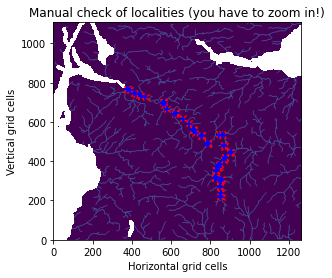

In [7]:
#Plotting resulting sample locations:
plt.figure()
plt.imshow(is_drainage.reshape(full_shape)+landmask,origin='lower') 
plt.scatter(x=sample_locs[:,0]/mg.dx, y=sample_locs[:,1]/mg.dx, marker="x",c='r', s=40)
plt.scatter(x=fitted_locs[:,0]/mg.dx, y=fitted_locs[:,1]/mg.dx, marker="+",c='b', s=40)
#plt.scatter(x=sample_locs[64,0]/mg.dx, y=sample_locs[64,1]/mg.dx, marker='.', c='k', s=40) #plotting point fursthest down stream
plt.scatter
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')
plt.title("Manual check of localities (you have to zoom in!)")

In the next cell, the geochemical data is loaded in. The composition of the farthest downstream sample is used as the initial guess for the inversion.

In [8]:
obs_data = pd.read_csv('Data/converted_chem_data.csv') #read in geochem data
elems =  obs_data.columns[1:].tolist() # List of element strings
obs_data[elems]=obs_data[elems].astype(float) # Cast numeric data to float


# setting initial composition:
obs_elems = obs_data[elems] # create array of concentrations for all elements
clyde_mth_comp = np.asarray(obs_elems[obs_data['SAMPLE_No'] == 700012]) # set initial composition


prior_wtd_avg = pd.DataFrame(clyde_mth_comp) #turn array into dataframe for easy access
prior_wtd_avg.columns = elems
#Future proofing: To expand model to several basins, can use the mean of farthest downstream compositions for initial guess
prior_wtd_avg = np.mean(prior_wtd_avg,axis=0) 
prior_wtd_avg_log = np.log(prior_wtd_avg)

## Generating drainage basin

As the model depends on downstream geochemical samples, it is only possible to predict the upstream source geochemistry for the upstream area of those models. The active drainage basin is found by finding the upstream drainage area for the sample that is farthest downstream.

In [9]:
model_width = mg.shape[1] # number of x cells in topographic model grid
model_height = mg.shape[0] # number of y cells in topographic model grid
lowest_sample = loc_nodes[sample_data[:,2]== '700012'] # Locality 700012
active_area = get_watershed_mask(mg,lowest_sample) # extract upstream area of most downstream Clyde sample 

Text(0, 0.5, 'Vertical Model Cells')

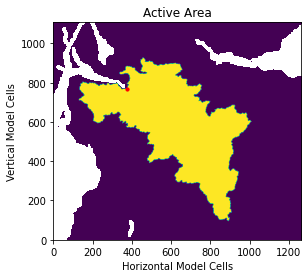

In [10]:
# Plotting the active drainage basin. Red point = lowest sample (700012).

plt.imshow(active_area.reshape(full_shape)+landmask,origin='lower')
plt.scatter(x=sample_locs[64,0]/mg.dx, y=sample_locs[64,1]/mg.dx, marker='.', c='r', s=40)
plt.title("Active Area")
plt.xlabel("Horizontal Model Cells")
plt.ylabel("Vertical Model Cells")

Since running the inversion on a $100 \times 100$ m grid would be computationally not possible, the drainage basin needs to be downsampled onto a workable resolution. For this example a 10 by 10 block grid is used. In the study a $84 \times 74$ node grid was used (relating to $\approx 1.5$ km$^2$/node).

In [11]:
# Defining the active blocks function:

def get_active_blocks(nx,ny):
    """For a given number of blocks in the x 
    and y direction (nx & ny), returns a (ny,nx) 
    bool array saying if cell overlaps with active 
    area or not. """
    
    block_width = np.ceil(model_width/nx) 
    block_height = np.ceil(model_height/ny)

    model_grid_block_indices = np.zeros((model_height,model_width,2))    
    for i in np.arange(model_height):
        for j in np.arange(model_width):
            model_grid_block_indices[i,j,0] = i//block_height
            model_grid_block_indices[i,j,1] = j//block_width
    model_grid_block_indices = model_grid_block_indices.astype(int)        
    # 3D array that contains index of block that model cell corresponds to 
    # ([:,:,0] = y coordinate; [:,:,1] = x coordinate)
    
    out = np.zeros((ny,nx)).astype(bool)
    for i in np.arange(ny):
        for j in np.arange(nx):
            # Boolean array of model cells that correspond to block indeix (i,j)
            cells_in_block = np.logical_and(model_grid_block_indices[:,:,0] == i, model_grid_block_indices[:,:,1] == j)
            # Returns if block overlap with active area:
            out[i,j] = np.any(np.logical_and(cells_in_block,active_area.reshape(full_shape)))
    return(out)

# Setting number of blocks and creating active blocks:
nx = 10
ny = 10
active_blocks = get_active_blocks(10,10)

Text(0, 0.5, 'Vertical Inversion Blocks')

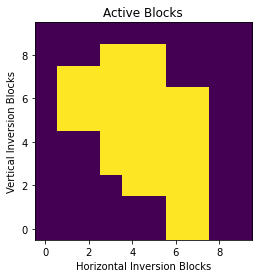

In [12]:
# Plotting active blocks area
plt.imshow(active_blocks,origin='lower')
plt.title("Active Blocks")
plt.xlabel("Horizontal Inversion Blocks")
plt.ylabel("Vertical Inversion Blocks")


### Generating unique upstream areas
The initial guess is further refined by setting the unique upstream area (UUA) of a sample to the concentration of that sample. First the (UUA) must be found. For this first the total upstream area for each element is needed, as this takes a while to run this data is provided.

In [13]:
# loading in upstream area of each locality:
unique_locs = np.unique(sample_data[:,2]) # catching duplicate samples
loc_areas = np.load('Data/loc_areas.npy')

The following functions are used in the `initiate_blocky_inversion_smart` to find the UUA of a sample and set the intial guess.

In [14]:
def loc_to_area(loc):
    """Returns the catchment mask for a given locality"""
    return(loc_areas[np.where(unique_locs == loc)])

def b_is_nested_in_a(a,b):
    """Is catchment 'b' a nested subcatchment of catchment 'a'?"""
    return(not(np.any(np.invert(np.logical_or(a,np.invert(b))))))

def which_locs_are_contained_upstream_of(loc_a):
    """Which localities define subcatchments of area defined by loc 'a'"""
    loc_area = loc_to_area(loc_a)
    out_locs = []
    for loc_num in unique_locs:
        if(not(loc_num==loc_a)):
            upst_area = loc_to_area(loc_num)
            if(b_is_nested_in_a(loc_area,upst_area)):
                out_locs = out_locs + [loc_num]
    return(out_locs)

def find_unique_seg(loc):
    locs_upstream_of_ = which_locs_are_contained_upstream_of(loc)
    downstream_area = loc_to_area(loc)
    out = np.zeros(active_area.size).astype(bool)
    for upstream_loc in locs_upstream_of_:
        out = np.logical_or(out,loc_to_area(upstream_loc))
    unique_seg = np.logical_and(downstream_area,np.invert(out))
    return(unique_seg.reshape(active_area.shape))

## Defining Inversion Functions
In the following all further functions that are needed for the inversion are defined.

### Expand function
To be able to map the inverse result properly and manipulate it the same as other maps, the result needs to be changed back from the $10 \times 10$ node grid to the $100 \times 100$ m grid.

In [15]:
def expand(block_grid,block_x,block_y):
    """Expands low res array of block heights into 
    model grid array that can be fed into topographic
    model. Note that blocks at the upper and eastern 
    perimeter are clipped if number of blocks doesn't 
    divide number of model cells. 
    
    block_x and block_y are the number of model cells 
    in each block in x and y dir respectively"""
    return(block_grid.repeat(block_y, axis=0).repeat(block_x, axis=1)[:model_height,:model_width])

### Misfit and Regularization
The following functions define the misfit, roughness and overall objective function. 

`data_misfit` runs the mixing based on the current guess for upstream source composition `bdrck_arr` and implements the equation: $||\log{(F(\textbf{C}))} - \log{(\textbf{D})}||^2$

where $F(\textbf{C})$ is the theoretical downstream composition and $\textbf{D}$ is the observed downstream geochemistry.
 
`cost_roughness` calculates the roughness, which is defined by the change of concentration in the x and y direction: $rough_x = \sqrt{\sum{\left(\frac{d\textbf{C}}{dx}\right)^2}}$ and $rough_y = \sqrt{\sum{\left(\frac{d\textbf{C}}{dy}\right)^2}}$

`smoothed_objective` implements the objective function that is then minimised:  $X(\textbf{C}) = ||\log{(F(\textbf{C}))} - \log{(\textbf{D})}||^2 + \lambda \left(rough_x + rough_y \right)$

where $\lambda$ is a hyperparameter controlling the effect roughness has on the solution.

In [16]:
def data_misfit(bdrck_arr,elem):
    """Returns L2norm data misfit for a given bedrock input array (mgkg), calculating predictions for given element assuming homogenous incision"""
    a, sed_comp = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node'],runoff = bdrck_arr)  # composition but homogeneous erosion
    sed_comp_norm = sed_comp/q_homo_incis
    l2norm = np.linalg.norm(np.log10(obs_data[elem]) - np.log10(sed_comp_norm[loc_nodes]))
    return(l2norm)   

In [17]:
def cost_roughness(blox,active_blox,block_x,block_y):
    """Returns l2 norm of roughness in both directions. 
    Assumes Von Neumann BCs dC/dx = dC/dy = 0"""
    copy = np.copy(blox)
    # Set von neumann BCs
    copy[np.invert(active_blox)] = 'nan' # set inactive nodes to 'nan'
    padded = np.pad(copy,pad_width=1,mode='constant',constant_values='nan') # pad with 'nan' too
    x_diffs = np.diff(padded,axis=1)/block_x # dC/dx
    y_diffs = np.diff(padded,axis=0)/block_y # dC/dy
    x_rough = np.sqrt(np.nansum(x_diffs**2)) # sqrt(SUM((dC/dx)^2)), NB 'nans' are treated as zeros using nansum.
    y_rough = np.sqrt(np.nansum(y_diffs**2)) # sqrt(SUM((dC/dy)^2))
    return(x_rough,y_rough) # return tuple of roughness along both axes


In [18]:
def smoothed_objective(param_arr,blox,active_blox,block_xstep,block_ystep,elem,lamda_):
    """Tests a given parameter array `param_arr` for the given inversion setup. 
    Returns the least squares damped cost. Each iteration is ~25 ms"""
    blox[active_blox] = param_arr # Update model grid with new parameters; 1.25 us
    bedrock = expand(np.exp(blox),block_xstep,block_ystep) # Convert log blocks into continuous grid in mg/kg; 3.5 ms
    data_sq = data_misfit(bedrock.reshape(flat_shape),elem)**2 # Calculate data misfit; 19.4 ms
    rough_x,rough_y = cost_roughness(blox,active_blox,block_xstep,block_ystep) # Calculate roughness; 68 us
    roughness_sq = (lamda_**2)*(rough_x**2 + rough_y**2) # Roughness squared; 0.6 us
    return(data_sq+roughness_sq)

### Initiating the inversion

Finally, `initiate_blocky_inversion_smart` initiates everything to set up the inversion. 

1. It sets the initial starting guess based on the UUA of each sample.
2. Defines the inversion grid and 
3. Downsamples the initial guess onto the grid

In [19]:
def initiate_blocky_inversion_smart(nx,ny,elem):
    """Initiates an inversion grid for given number of 
    cells and element. """
    
    # Define full-res starting solution
    full_init = np.zeros(active_area.shape) + prior_wtd_avg_log[elem]  
    for loc_num in unique_locs:
        values = np.asarray(obs_elems[elem][obs_data['SAMPLE_No'] == float(loc_num)])
        if(values.size==2): # Catch duplicate sample exception
            full_init[find_unique_seg(loc_num)] = np.mean(np.log(values))
        else:
            full_init[find_unique_seg(loc_num)] = np.log(values)

    # Define inversion nodes
    blox = np.zeros((ny,nx))
    active_blox = get_active_blocks(nx,ny) # Active cells
    
    block_x_step = np.ceil(model_width/nx) # Block width
    block_y_step = np.ceil(model_height/ny) # Block height
    
    # Downsample initial guess
    model_grid_block_indices = np.zeros((model_height,model_width,2))
    for i in np.arange(model_height):
        for j in np.arange(model_width):
            model_grid_block_indices[i,j,0] = i//block_y_step
            model_grid_block_indices[i,j,1] = j//block_x_step
    model_grid_block_indices = model_grid_block_indices.astype(int)
    # 3D array that contains index of block that model cell corresponds to
    # ([:,:,0] = y coordinate; [:,:,1] = x coozzzrdinate)
     
    for i in np.arange(ny):
        for j in np.arange(nx):
            # Boolean array of model cells that correspond to block indeix (i,j)
            cells_in_block = np.logical_and(model_grid_block_indices[:,:,0] == i, model_grid_block_indices[:,:,1] == j)
            # Returns if block overlap with active area:
            blox[i,j] = np.mean(full_init.reshape(full_shape)[cells_in_block])
    blox[np.invert(active_blox)] =  prior_wtd_avg_log[elem]     
    return blox,active_blox,block_x_step,block_y_step

## Running the inversion

With everything set up, the inversion can now be run. For this example the inversion is run for a single lambda ($10^{-0.3}$). This should take around 4 minutes to complete.

Optimization terminated successfully.
         Current function value: 0.529664
         Iterations: 9
         Function evaluations: 4034
############ results ############
Runtime =  283.03344559669495 s
True
0
Optimization terminated successfully.
9


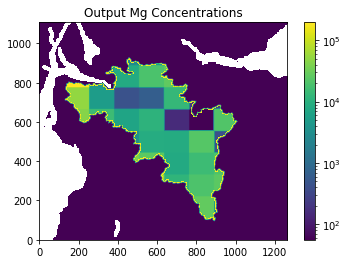

In [20]:

nx=10 #  # <<<<<<<<<<<<<<<<   Change number of x blocks in inversion grid
ny=10 #  # <<<<<<<<<<<<<<<<   Change number of y blocks in inversion grid
lamda=-0.3 # <<<<<<<<<<<<<<<<   Change smoothing coefficient 
elem='Mg' # <<<<<<<<<<<<<<<<  Change element being inverted

### Initiating inversion ####

blocks,active_blocks,block_width,block_height = initiate_blocky_inversion_smart(nx,ny,elem)

parameters = np.copy(blocks[active_blocks]) # The array we will vary. 

#### Perform inversion ####

start = time.time()
res_nm = sp.optimize.minimize(fun=smoothed_objective,args=(blocks,active_blocks,block_width,block_height,elem,lamda),x0=parameters,method='Powell',
                                  options={'disp':True,'xtol':1e-3,'ftol':1e-3})
end = time.time()

#### Finish ####

print("############ results ############")
print("Runtime = ",end-start,"s")
print(res_nm.success) 
print(res_nm.status)
print(res_nm.message)
print(res_nm.nit)

expanded = expand(np.exp(blocks),block_width,block_height)
expanded[np.invert(active_area.reshape(full_shape))] = 'nan'
plt.imshow(active_area.reshape(full_shape)+landmask,origin='lower')
plt.imshow(expanded+landmask,origin='lower',norm=LogNorm())
plt.colorbar()
plt.title("Output Mg Concentrations")
plt.show()
